# OPT 7 - Projet : Sentiment Analysis for Tweets

**Théo Cornille - Mirwaisse Djanbaz - Luc Gibaud - Cédric des Lauriers**

### Dataset : Sentiment dataset with 1.6 million tweets

"According to the creators of the dataset:

"Our approach was unique because our training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like 🙂, were positive, and tweets with negative emoticons, like 😞, were negative. We used the Twitter Search API to collect these tweets by using keyword search"

citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12

## Présentation

Nous disposons de 1.6 millions de tweets qui ont été extraits en utilisant l'API de Twitter. Ces tweets ont été annotés (0 = tweet négatif, 4 = tweet positif).

Notre objectif est d'utiliser cette base de données afin de pouvoir prédir automatiquement le sentiment qu'un auteur a voulu donner à son tweet.

In [188]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category =RuntimeWarning)
warnings.simplefilter(action='ignore', category=DataConversionWarning)

In [1]:
import os, string, collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from utils import *
import re

from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import metrics

from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D, Input 
from keras.layers import GlobalMaxPooling1D, concatenate, LSTM, Bidirectional, SimpleRNN, GRU
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

D:\Programmes\Anaconda2\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## I. Import et exploration de la base de données

In [2]:
filepath = r"C:\Users\MyPC\Documents\AIC-partage\Structured\data\training.1600000.processed.noemoticon.csv"

In [3]:
df = pd.read_csv(filepath, encoding = "ISO-8859-1", header = None, names = ["target", "id", "date", "flag", "user", "text"], sep =",")

In [4]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


La colonne "target" n'est composé que de 0 (=tweet négatif) et de 4 (=tweet positif). Afin de simplifier nous allons transformer les 4 et 1. Nous gardons donc:

- 0 =tweet négatif
- 1 = tweet positif

In [5]:
df.target = df.target.replace(4, 1)

In [6]:
df = df.iloc[:, [5, 0]]

In [7]:
df.columns = ['text', 'sentiment']

In [8]:
df.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [9]:
# On limite pour le moment la taille du dataset pour accélérer les calculs
df = df.sample(frac=1)
df = df[:200000]
df = df.reset_index(drop=True)

In [10]:
df['sentiment'].value_counts()

1    100145
0     99855
Name: sentiment, dtype: int64

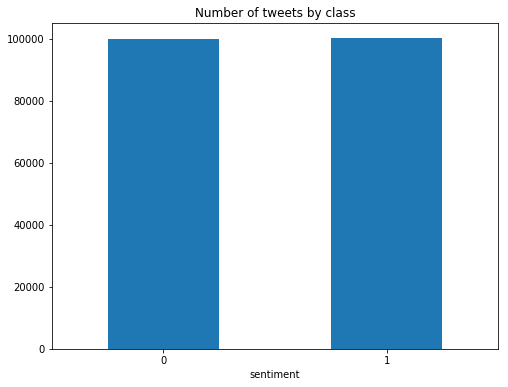

In [11]:
df.groupby(['sentiment']).count().plot(kind='bar', figsize=(8, 6), rot=0, legend=False, title='Number of tweets by class')
plt.show()

## II. Preprocessing des données

Text Cleaning

In [12]:
class TextCleaner(BaseEstimator, TransformerMixin):    
    def remove_mentions(self, text):        
        return re.sub(r'@\w+', '', text)
    
    def remove_urls(self, text):        
        return re.sub(r'http.?://[^\s]+[\s]?', '', text)
    
    def only_characters(self, text):
        return re.sub('[^a-zA-Z\s]', '', text)
    
    def remove_extra_spaces(self, text):
        text = re.sub("\s+", ' ', text)
        text = text.lstrip()
        return text.rstrip()
    
    def to_lower(self, text):
        return text.lower()
    
    def fix_words(self, text):
        #text = re.sub(r'\bthx\b', 'thanks', text)
        pass
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):        
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.only_characters).apply(self.remove_extra_spaces).apply(self.to_lower)
        return clean_X

In [13]:
tc = TextCleaner()
df['clean_text'] = tc.transform(df['text'])

In [14]:
df.head()

,text,sentiment,clean_text
0,"@tifftiff621 hmm, just realized it's 11. I hav...",0,hmm just realized its i have to be at school a...
1,@spectrummother Thank you for your kind words.,1,thank you for your kind words
2,"@taylorswift13 , finally, someone spreading th...",1,finally someone spreading the hayley love via ...
3,ohhh i ate too much candy now i have a tummy a...,0,ohhh i ate too much candy now i have a tummy ache
4,@ClaireMcKenna1 I'll be there as soon as I can!,1,ill be there as soon as i can


Tokenizer

In [198]:
def tokenize(s): 
    return s.split()

In [16]:
df['tokenized'] = df['clean_text'].apply(lambda row: tokenize(row))

In [17]:
df.head()

,text,sentiment,clean_text,tokenized
0,"@tifftiff621 hmm, just realized it's 11. I hav...",0,hmm just realized its i have to be at school a...,"[hmm, just, realized, its, i, have, to, be, at..."
1,@spectrummother Thank you for your kind words.,1,thank you for your kind words,"[thank, you, for, your, kind, words]"
2,"@taylorswift13 , finally, someone spreading th...",1,finally someone spreading the hayley love via ...,"[finally, someone, spreading, the, hayley, lov..."
3,ohhh i ate too much candy now i have a tummy a...,0,ohhh i ate too much candy now i have a tummy ache,"[ohhh, i, ate, too, much, candy, now, i, have,..."
4,@ClaireMcKenna1 I'll be there as soon as I can!,1,ill be there as soon as i can,"[ill, be, there, as, soon, as, i, can]"


remove stopwords

In [18]:
#nltk.download('stopwords')

In [19]:
stop = set(stopwords.words('english'))
stop.update(['amp', 'rt', 'cc'])
stop = stop - set(['no', 'not'])

In [20]:
def remove_stopwords(row):
    return [t for t in row if t not in stop]

In [21]:
df['tokenized'] = df['tokenized'].apply(lambda row: remove_stopwords(row))

In [22]:
pd.set_option('display.max_colwidth', -1)

In [23]:
df[['text', 'tokenized']].head()

,text,tokenized
0,"@tifftiff621 hmm, just realized it's 11. I have to be at school at 12. and I have a 45 min drive ouch. I'll chat when i get back.","[hmm, realized, school, min, drive, ouch, ill, chat, get, back]"
1,@spectrummother Thank you for your kind words.,"[thank, kind, words]"
2,"@taylorswift13 , finally, someone spreading the Hayley Love via Twitter. Welcome to the club, Taylor.","[finally, someone, spreading, hayley, love, via, twitter, welcome, club, taylor]"
3,ohhh i ate too much candy now i have a tummy ache,"[ohhh, ate, much, candy, tummy, ache]"
4,@ClaireMcKenna1 I'll be there as soon as I can!,"[ill, soon]"


### Création du vocabulaire

In [24]:
def update_vocab_counter(row):
    for word in row:
        vocab_counter[word] += 1

In [25]:
vocab_counter = collections.Counter()
df['tokenized'].apply(update_vocab_counter);
vocab = sorted(vocab_counter, key=vocab_counter.get, reverse=True)

In [26]:
len(vocab)

102003

In [27]:
import operator
words_count = sorted(vocab_counter.items(), key=operator.itemgetter(1), reverse=True)

In [28]:
rank=[]
frequency=[]
for i, c in enumerate(words_count):
    rank.append(i)
    frequency.append(c[1])

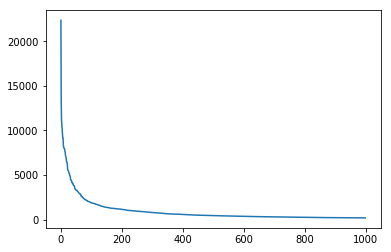

In [29]:
plt.plot(rank[:1000], frequency[:1000])
plt.show()

In [30]:
#top 1000 des tokens les plus fréquents
print(vocab[:1000])

['im', 'not', 'good', 'day', 'get', 'like', 'go', 'no', 'dont', 'going', 'love', 'today', 'work', 'cant', 'got', 'back', 'time', 'lol', 'u', 'know', 'one', 'really', 'see', 'well', 'still', 'new', 'night', 'want', 'think', 'home', 'thanks', 'oh', 'last', 'much', 'need', 'miss', 'morning', 'hope', 'great', 'ill', 'tomorrow', 'twitter', 'haha', 'feel', 'thats', 'sad', 'fun', 'right', 'wish', 'didnt', 'sleep', 'would', 'bad', 'happy', 'sorry', 'tonight', 'come', 'make', 'way', 'getting', 'gonna', 'though', 'better', 'watching', 'ive', 'nice', 'bed', 'yeah', 'wait', 'could', 'youre', 'school', 'week', 'hate', 'people', 'days', 'even', 'hey', 'awesome', 'next', 'weekend', 'thank', 'yes', 'soon', 'never', 'little', 'long', 'working', 'say', 'take', 'please', 'watch', 'first', 'tired', 'best', 'wanna', 'feeling', 'show', 'ok', 'done', 'x', 'wont', 'sick', 'always', 'everyone', 'friends', 'life', 'thing', 'us', 'already', 'sure', 'another', 'made', 'cool', 'looking', 'something', 'find', 'read

In [31]:
#On limite la taille du dictionnaire aux 100000 tokens les plus fréquents
max_words = 5000

In [32]:
#Dictionnaire qui map les tokens avec leur ID.

In [33]:
w2id = {w:i for i, w in enumerate(vocab[:max_words])}

In [34]:
#On remplace les autres tokens par unk

In [35]:
w2id['unk'] = 0

In [36]:
def transform_to_ids(row):
    return [w2id[w] if w in w2id else w2id['unk'] for w in row]

In [37]:
df['tokenized_int'] = df['tokenized'].apply(lambda x: transform_to_ids(x))

## Naive Bayes

A la place d'utiliser juste la fréquence des termes, on choisit d'utiliser tf-idf pour apporter plus de justesse dans notre classification
On peut également vectoriser en bi-gramme, tri-gramme.

**Split dataset into train and valid**

Tf-idf

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 2), max_df=0.75, min_df=3, sublinear_tf=True)

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(df['clean_text'].values, df['sentiment'].values, test_size=0.20, random_state=42)

In [40]:
tfidf_train = vect.fit_transform(X_train)
tfidf_valid = vect.transform(X_valid)

In [41]:
def naive_bayes(x, y):
    r = []; b = []
    labels = np.unique(y)

    for l in labels:
        other_l = labels[labels != l]
        p = x[y == l].sum(0) + 1 #sum of tfidf vectors of label = 1
        q = x[y == other_l].sum(0) + 1 #sum of tfidf vectors of label = 0
        r.append(np.log((p/p.sum())/(q/q.sum()))) #log ratio
        b.append(np.log(len(p)/len(q))) #ratio of position and negative
    
    return r, b

In [42]:
r, b = naive_bayes(tfidf_train, y_train)

pre_preds = []
for j in range(len(r)):
    pre_preds.append(np.asarray(tfidf_valid @ r[j].T + b[j]).reshape(-1))
arr = np.array(pre_preds)

In [43]:
metrics.accuracy_score(y_valid, np.argmax(arr.T, axis=1))

0.788875

In [44]:
print(metrics.classification_report(y_valid, np.argmax(arr.T, axis=1)))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79     20015
           1       0.80      0.77      0.78     19985

   micro avg       0.79      0.79      0.79     40000
   macro avg       0.79      0.79      0.79     40000
weighted avg       0.79      0.79      0.79     40000



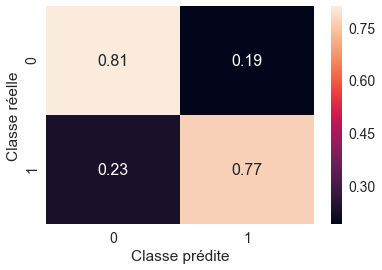

In [45]:
array = metrics.confusion_matrix(y_valid, np.argmax(arr.T, axis=1))
array = array.astype('float') / array.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(array, range(2),range(2))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.show()

## Logistic Regression

Cross validation with 5 folds

In [46]:
model = LogisticRegression()
model.fit(tfidf_train, y_train)

D:\Programmes\Anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [47]:
preds = model.predict(tfidf_valid)
accuracy = (preds == y_valid).mean()
print('accuracy:', accuracy)

accuracy: 0.802875


In [48]:
print(metrics.classification_report(y_valid, preds))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80     20015
           1       0.80      0.81      0.80     19985

   micro avg       0.80      0.80      0.80     40000
   macro avg       0.80      0.80      0.80     40000
weighted avg       0.80      0.80      0.80     40000



**Visualisation des tokens**

In [49]:
def get_tokens_coefs(vocab, coefs, n):
    coef_df = pd.DataFrame({'vocab': vocab, 'coef':coefs.reshape(-1)})
    return coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:n]

In [50]:
def plot_tokens_coefs(df, ax, label):
    df.sort_values('coef').plot.barh(legend=False, ax=ax)
    ax.set_yticklabels(df['vocab'].values.tolist()[::-1])
    ax.set_title(label);

In [51]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
sn.set_style(style='white')

In [52]:
model.coef_[0]

array([ 1.00841151,  0.39923298, -0.77764772, ...,  0.10981471,
        0.14810159, -0.03228473])

In [53]:
model.coef_.shape

(1, 95990)

In [54]:
vocab = vect.get_feature_names()
n_coefs = 30

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
fig.subplots_adjust(wspace=0.8)

for i, l in enumerate(['positif','negatif']):
    coef_df = get_tokens_coefs(vocab, model.coef_, n_coefs)
    plot_tokens_coefs(coef_df, axs[i], l)

## Linear model

Train - Test split

In [55]:
X_train, X_valid, y_train, y_valid = train_test_split(df['tokenized_int'].values, df['sentiment'].values, test_size=0.25, random_state=0)

Nous allons créé un réseau de neurones avec une couche embedding de dimension 100 comme input et aucune couche cachée.
C'est équivalent à appliquer une régression logistique sur les vecteurs mots au lieu de l'appliquer aux vecteurs 1hot

In [56]:
def baseline_model():
    model = Sequential([Embedding(input_dim=max_words, output_dim=50, input_length=maxlen),
                        Flatten(),
                        Dense(2, activation='sigmoid')])

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

Pour ce modèle, les vecteurs mots ont besoin d'être de taille fixé

- limitation de la longueur d'un tweet

In [57]:
lens = df['tokenized_int'].apply(lambda x: len(x))

In [58]:
min(lens), max(lens), np.mean(lens)

(0, 32, 7.253255)

In [59]:
maxlen = 10

On choisit donc une longueur de tweet maximale de 10

On remplit les vecteurs/phrases de taille inférieure à 10 avec des -1 (représentant les mot de type 'unk').

In [60]:
x_train = pad_sequences(X_train, maxlen=maxlen, value=0)
x_valid = pad_sequences(X_valid, maxlen=maxlen, value=0)

In [61]:
x_train[0]

array([  43,    5,    7,  106,   76,   14,  452,    0,   11, 4065])

On encode les classes en 1hot vector:

In [62]:
hot_y = np_utils.to_categorical(y_train)
hot_y_valid = np_utils.to_categorical(y_valid)

model training

In [63]:
model = baseline_model()
model.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=5, batch_size=100)

Train on 150000 samples, validate on 50000 samples
Epoch 1/5
150000/150000 [==============================] - 8s 52us/step - loss: 0.5199 - acc: 0.7456 - val_loss: 0.4862 - val_acc: 0.7685
Epoch 2/5
150000/150000 [==============================] - 7s 48us/step - loss: 0.4657 - acc: 0.7846 - val_loss: 0.4904 - val_acc: 0.7676
Epoch 3/5
150000/150000 [==============================] - 7s 48us/step - loss: 0.4403 - acc: 0.7994 - val_loss: 0.5032 - val_acc: 0.7615
Epoch 4/5
150000/150000 [==============================] - 7s 48us/step - loss: 0.4135 - acc: 0.8151 - val_loss: 0.5245 - val_acc: 0.7552
Epoch 5/5
150000/150000 [==============================] - 7s 48us/step - loss: 0.3918 - acc: 0.8270 - val_loss: 0.5483 - val_acc: 0.7493


In [64]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss=model.history.history['loss']
val_loss=model.history.history['val_loss']

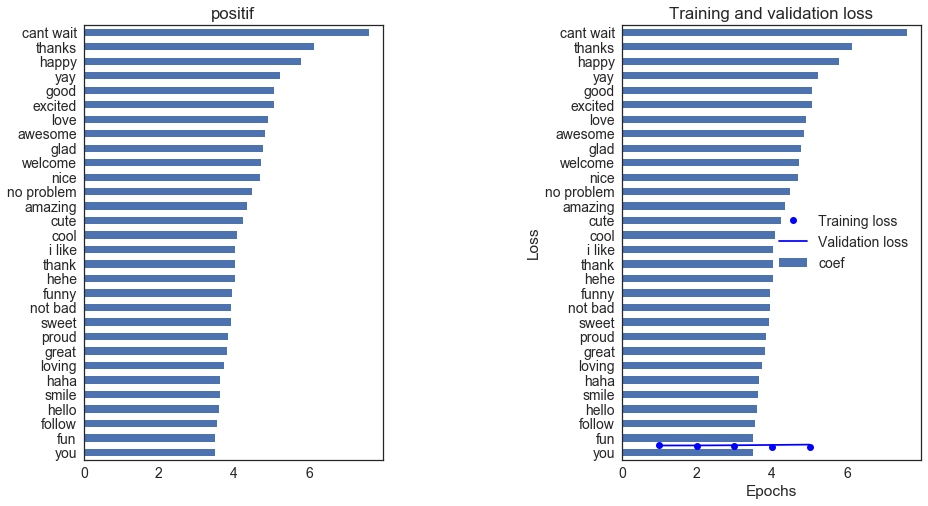

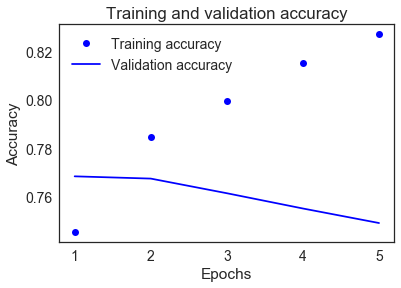

In [65]:
num_epochs=range(1,len(loss)+1)

plt.plot(num_epochs, loss, 'bo', label='Training loss')
plt.plot(num_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(num_epochs, acc, 'bo', label='Training accuracy')
plt.plot(num_epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Convolutional Neural Network

Nous allons créé un réseau de neurones convolutionel très simple. Il dispose d'une couche de convolution (10 filtres de taille 3).

In [66]:
def conv_model():
    model = Sequential([Embedding(input_dim=max_words, output_dim=32, input_length=maxlen),
                        Convolution1D(10, 3, padding='same', activation='relu'),
                        MaxPooling1D(),
                        Flatten(),
                        Dense(50, activation='relu'),
                        Dense(2, activation='sigmoid')])

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [67]:
convmodel = conv_model()
convmodel.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=5, batch_size=100)

Train on 150000 samples, validate on 50000 samples
Epoch 1/5
150000/150000 [==============================] - 11s 76us/step - loss: 0.5040 - acc: 0.7522 - val_loss: 0.4789 - val_acc: 0.7725
Epoch 2/5
150000/150000 [==============================] - 10s 69us/step - loss: 0.4468 - acc: 0.7919 - val_loss: 0.4714 - val_acc: 0.7729
Epoch 3/5
150000/150000 [==============================] - 10s 69us/step - loss: 0.4137 - acc: 0.8112 - val_loss: 0.4791 - val_acc: 0.7701
Epoch 4/5
150000/150000 [==============================] - 10s 69us/step - loss: 0.3783 - acc: 0.8324 - val_loss: 0.5049 - val_acc: 0.7663
Epoch 5/5
150000/150000 [==============================] - 10s 68us/step - loss: 0.3430 - acc: 0.8510 - val_loss: 0.5296 - val_acc: 0.7566


In [68]:
training_loss_value, training_acc_value = convmodel.evaluate(x_train, hot_y, batch_size=100)
valid_loss_value, valid_acc_value = convmodel.evaluate(x_valid, hot_y_valid, batch_size=100)

50000/50000 [==============================] - 1s 15us/step


In [69]:
print('training loss : {:.4f}'.format(training_loss_value))
print('validation_loss : {:.4f}'.format(valid_loss_value))
print(' ')
print('training accuracy : {:.2f} %'.format(100*training_acc_value))
print('validation accuracy : {:.2f} %'.format(100*valid_acc_value))

training loss : 0.2889
validation_loss : 0.5296
 
training accuracy : 88.73 %
validation accuracy : 75.66 %


Nous allons maintenant créé un réseau de neurones convolutionnel un peu plus complexe qui appliquent différents tailles de filtres (taille 2, 3 et 5).

In [70]:
def mult_conv():
    graph_in = Input(shape=(max_words, 50))

    convs = []
    for filter_size in range(2, 5):
        x = Convolution1D(64, filter_size, padding='same', activation='relu')(graph_in)
        convs.append(x)

    graph_out = concatenate(convs, axis=1)
    graph_out = GlobalMaxPooling1D()(graph_out)
    graph = Model(graph_in, graph_out)
    
    model = Sequential([Embedding(max_words, 50, input_length=maxlen),
                    graph,
                    Dropout(0.5),
                    Dense(25, activation='relu'),
                    Dense(2, activation='sigmoid')])

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [71]:
multconv = mult_conv() 
multconv_history = multconv.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=5, batch_size=100)

Train on 150000 samples, validate on 50000 samples
Epoch 1/5
150000/150000 [==============================] - 36s 238us/step - loss: 0.5183 - acc: 0.7417 - val_loss: 0.4744 - val_acc: 0.7733
Epoch 2/5
150000/150000 [==============================] - 32s 210us/step - loss: 0.4609 - acc: 0.7847 - val_loss: 0.4674 - val_acc: 0.7772
Epoch 3/5
150000/150000 [==============================] - 32s 215us/step - loss: 0.4372 - acc: 0.7977 - val_loss: 0.4689 - val_acc: 0.7767
Epoch 4/5
150000/150000 [==============================] - 31s 209us/step - loss: 0.4153 - acc: 0.8088 - val_loss: 0.4712 - val_acc: 0.7750
Epoch 5/5
150000/150000 [==============================] - 26s 172us/step - loss: 0.3931 - acc: 0.8212 - val_loss: 0.4841 - val_acc: 0.7734


In [72]:
acc = multconv_history.history['acc']
val_acc = multconv_history.history['val_acc']
loss = multconv_history.history['loss']
val_loss = multconv_history.history['val_loss']

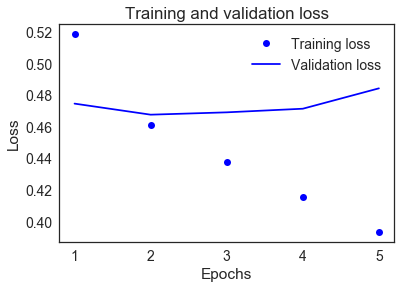

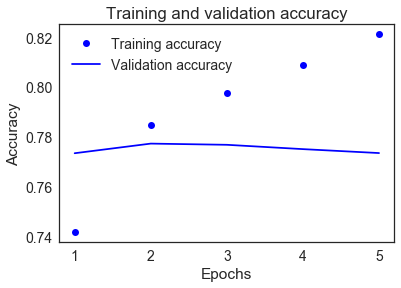

In [73]:
num_epochs=range(1,len(loss)+1)

plt.plot(num_epochs, loss, 'bo', label='Training loss')
plt.plot(num_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(num_epochs, acc, 'bo', label='Training accuracy')
plt.plot(num_epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [74]:
training_loss_value, training_acc_value = multconv.evaluate(x_train, hot_y, batch_size=100)
valid_loss_value, valid_acc_value = multconv.evaluate(x_valid, hot_y_valid, batch_size=100)

50000/50000 [==============================] - 2s 31us/step


In [75]:
print('training loss : {:.4f}'.format(training_loss_value))
print('validation_loss : {:.4f}'.format(valid_loss_value))
print(' ')
print('training accuracy : {:.2f} %'.format(100*training_acc_value))
print('validation accuracy : {:.2f} %'.format(100*valid_acc_value))

training loss : 0.3416
validation_loss : 0.4841
 
training accuracy : 85.34 %
validation accuracy : 77.34 %


## SimpleRNN

In [76]:
def simple_rnn():
    model = Sequential()
    model.add(Embedding(max_words, 50, input_length=maxlen))
    model.add(SimpleRNN(32))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [77]:
simplernn = simple_rnn() 
simplernn_history = simplernn.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=1, batch_size=100)

Train on 150000 samples, validate on 50000 samples
Epoch 1/1
150000/150000 [==============================] - 11s 75us/step - loss: 0.5101 - acc: 0.7498 - val_loss: 0.4884 - val_acc: 0.7664


## LSTM

- couteux en temps computationnel mais très bon en représentation

In [78]:
def simple_lstm():
    model = Sequential()
    model.add(Embedding(max_words, 50, input_length=maxlen))
    model.add(LSTM(32))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [79]:
simplelstm = simple_lstm() 
simplelstm_history = simplelstm.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=1, batch_size=100)

Train on 150000 samples, validate on 50000 samples
Epoch 1/1
150000/150000 [==============================] - 16s 110us/step - loss: 0.5037 - acc: 0.7534 - val_loss: 0.4767 - val_acc: 0.7718


## GRU

- similaire au lstm
- compromis en temps computationnel et représentation

In [80]:
def simple_gru():
    model = Sequential()
    model.add(Embedding(max_words, 50, input_length=maxlen))
    model.add(GRU(32))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [81]:
simplegru = simple_gru() 
simplegru_history = simplegru.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=1, batch_size=100)

Train on 150000 samples, validate on 50000 samples
Epoch 1/1
150000/150000 [==============================] - 16s 109us/step - loss: 0.5037 - acc: 0.7542 - val_loss: 0.4753 - val_acc: 0.7740


## BI LSTM

Pas très utile mais à tester quand même

# Modèle final choisi

Nous allons donc choisir le modèle le plus performant en temps computationnel et pouvoir de représentation.

Au vu de nos données, tweets de taille assez courts (moyenne de mots dans un tweet = 8), nous choisissons donc un réseau de neurones convolutionnel

### Pre-trained word embeddings

Nous allons utiliser un modèle pré-entrainé à l'aide de GloVe pour améliorer notre modèle.

Nous allons utilisé des words vectors pré-entrainé.

Nous téléchargeons le fichier suivant:
- Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): glove.twitter.27B.zip

url : https://nlp.stanford.edu/projects/glove/

In [82]:
glove_dir = r'C:\Users\MyPC\Documents\AIC-partage\Structured\data'

In [83]:
embeddings_index = {}
f = open(glove_dir + '\glove.twitter.27B.50d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [84]:
len(embeddings_index)

1193514

In [85]:
def create_embedding_matrix(max_words, embedding_dim):
    embedding_matrix = np.zeros((max_words, embedding_dim))
    found = 0
    for word, i in w2id.items():
        embedding_vector = embeddings_index.get(word)
        if i < max_words:
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                found += 1
            else:
                embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))
    return embedding_matrix, found

In [86]:
embedding_matrix, found = create_embedding_matrix(max_words, 50)

In [87]:
found

4948

## CNN

In [88]:
def cnn_model():
    model = Sequential()
    # trainable = False poids de glove non mis à jour, meilleurs résultats avec trainable = True  
    model.add(Embedding(input_dim=max_words, output_dim=50 , weights=[embedding_matrix],  input_length=maxlen, trainable=True))
    model.add(Convolution1D(10, 3, padding='same', activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))
    
    #model.layers[0].set_weights = [embedding_matrix]
    #model.layers[0].trainable = True

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [89]:
cnn = cnn_model() 
cnn_history = cnn.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=5, batch_size=100)

Train on 150000 samples, validate on 50000 samples
Epoch 1/5
150000/150000 [==============================] - 15s 100us/step - loss: 0.5773 - acc: 0.6966 - val_loss: 0.5008 - val_acc: 0.7668
Epoch 2/5
150000/150000 [==============================] - 11s 76us/step - loss: 0.5034 - acc: 0.7612 - val_loss: 0.4879 - val_acc: 0.7743
Epoch 3/5
150000/150000 [==============================] - 11s 70us/step - loss: 0.4884 - acc: 0.7716 - val_loss: 0.4817 - val_acc: 0.7741
Epoch 4/5
150000/150000 [==============================] - 12s 79us/step - loss: 0.4794 - acc: 0.7778 - val_loss: 0.4925 - val_acc: 0.7676
Epoch 5/5
150000/150000 [==============================] - 12s 82us/step - loss: 0.4743 - acc: 0.7794 - val_loss: 0.4792 - val_acc: 0.7744


In [90]:
acc = cnn_history.history['acc']
val_acc = cnn_history.history['val_acc']
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

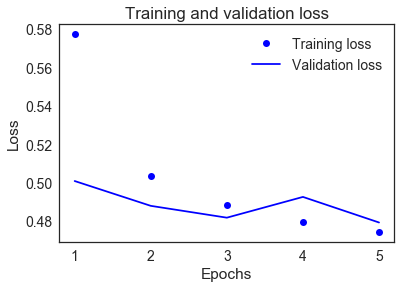

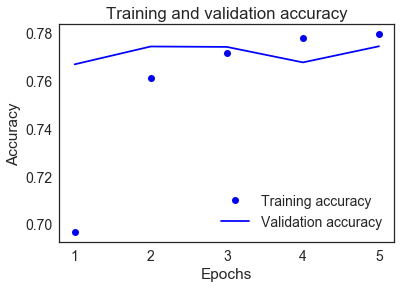

In [91]:
num_epochs=range(1,len(loss)+1)

plt.plot(num_epochs, loss, 'bo', label='Training loss')
plt.plot(num_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(num_epochs, acc, 'bo', label='Training accuracy')
plt.plot(num_epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [92]:
training_loss_value, training_acc_value = cnn.evaluate(x_train, hot_y, batch_size=100)
valid_loss_value, valid_acc_value = cnn.evaluate(x_valid, hot_y_valid, batch_size=100)

50000/50000 [==============================] - 1s 17us/step


In [93]:
print('training loss : {:.4f}'.format(training_loss_value))
print('validation_loss : {:.4f}'.format(valid_loss_value))
print(' ')
print('training accuracy : {:.2f} %'.format(100*training_acc_value))
print('validation accuracy : {:.2f} %'.format(100*valid_acc_value))

training loss : 0.4504
validation_loss : 0.4792
 
training accuracy : 79.90 %
validation accuracy : 77.44 %


In [169]:
def mult_conv_glove():
    graph_in = Input(shape=(max_words, 50))

    convs = []
    for filter_size in range(2, 5):
        x = Convolution1D(64, filter_size, padding='same', activation='relu')(graph_in)
        convs.append(x)

    graph_out = concatenate(convs, axis=1)
    graph_out = GlobalMaxPooling1D()(graph_out)
    graph = Model(graph_in, graph_out)
    
    model = Sequential([Embedding(max_words, 50,weights=[embedding_matrix],  input_length=maxlen, trainable=True ),
                    graph,
                    Dropout(0.5),
                    Dense(25, activation='relu'),
                    Dense(2, activation='sigmoid')])
    
    
   
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

## cnn_glove est le modèle qu'on va utliser pour le transfer learning et pour l'analyse de tweet en temps réel

Rq : Dans la suite on va utliser le modèle cnn_glove avec des embeddings de glove qu'on a modifié lors de l'entrainement (trainable = true ) pour l'exemple, pour autant il peut être judicieux de les fixer quand on entraine cnn_glove pour avoir une meilleur généalisation lors du tranfert

In [170]:
# moins tendance à overfit quand trainable = False 

cnn_glove = mult_conv_glove() 
cnn_history = cnn_glove.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=5, batch_size=100)

Train on 150000 samples, validate on 50000 samples
Epoch 1/5
150000/150000 [==============================] - 29s 192us/step - loss: 0.5427 - acc: 0.7238 - val_loss: 0.4767 - val_acc: 0.7721
Epoch 2/5
150000/150000 [==============================] - 28s 186us/step - loss: 0.4746 - acc: 0.7764 - val_loss: 0.4649 - val_acc: 0.7780
Epoch 3/5
150000/150000 [==============================] - 28s 187us/step - loss: 0.4566 - acc: 0.7866 - val_loss: 0.4613 - val_acc: 0.7795
Epoch 4/5
150000/150000 [==============================] - 28s 186us/step - loss: 0.4450 - acc: 0.7924 - val_loss: 0.4607 - val_acc: 0.7817
Epoch 5/5
150000/150000 [==============================] - 28s 188us/step - loss: 0.4363 - acc: 0.7971 - val_loss: 0.4617 - val_acc: 0.7813


# Transfer learning 
Quand on a peu de données avec tweet airline le transfer est bénéfique pour l'apprentissage.
Le transfer prévient du sur apprentissage du modèle.

Pour procéder au transfer : 
- On entraîne un modèle au préalable : ici cnn_glove un réseau multicouche de convolution avec des Embeddings pré-entrainé (cf ci dessus),  déterminer si on fixe ou non les poids des embeddings lors l'entrainement de cnn_glove (a priori mieux de les laisser fixé pour une meilleur généralisation )

- On fixe les poids des premières couches de cnn_glove (features obtenues à l'aide de la base de tweet initiale )

- On enlève (dans notre cas ) les 2 dernières couches dense et on les remplace (au choix ) par 2 couches de dropout et de dense pour les adapter au nouveau problème de classification du transfert (ici aussi 2 classes )  

Rq : on applique bien évidement le même préprocessing sur les nouvelles données 

In [97]:
# Freeze the layers except the last 2 layers
# on va enlever les 2 dernirère couches dense pour appliquer le transfer ensuite
for layer in cnn_glove.layers[:-2]:
    layer.trainable = False
 
 
# Check the trainable status of the individual layers
for layer in cnn_glove.layers:
    print(layer, layer.trainable)

<keras.layers.embeddings.Embedding object at 0x000002E4E4494160> False
<keras.engine.training.Model object at 0x000002E4E449B898> False
<keras.layers.core.Dropout object at 0x000002E4E4492EB8> False
<keras.layers.core.Dense object at 0x000002E4E4490400> True
<keras.layers.core.Dense object at 0x000002E4E448FF98> True


In [145]:
Tweet_airline= pd.read_csv(r"C:\Users\MyPC\Documents\AIC-partage\Structured\data\Tweets.csv")
Tweet_airline= Tweet_airline[Tweet_airline.airline_sentiment !="neutral"]
Tweet_airline = Tweet_airline[["text", "airline_sentiment"]]

# on ne garde qu'une petite partie : pour voir l'interet du transfer learning  
Tweet_airline = Tweet_airline.sample(frac=1)
Tweet_airline = Tweet_airline[:100]

Tweet_airline.head()

,text,airline_sentiment
6359,@SouthwestAir flight at 630 from fll kiosk just opened. Rude attendants because now everyone is Late Flight. http://t.co/2Boh2Mh3cb,negative
7045,I hate you all. RT @JetBlue: Our fleet's on fleek. http://t.co/uTdfqF5WPA,negative
6738,@SouthwestAir flight was Cancelled Flightled and it won't let me rebook online. Wait time on phone is too long. Please help,negative
12189,"@AmericanAir \nNot giving you a hard time...Just looking for basic customer service after AA lost my bag. ETA on it's return, please????????",negative
793,"@united for an early flt, I think a call is appropriate. Yes, reviewed and nada avail until next day. Expect full refund",negative


In [146]:
df2 = Tweet_airline
df2['clean_text'] = tc.transform(df2['text'])
df2['tokenized'] = df2['clean_text'].apply(lambda row: tokenize(row))
df2['tokenized'] = df2['tokenized'].apply(lambda row: remove_stopwords(row))
df2['tokenized_int'] = df2['tokenized'].apply(lambda x: transform_to_ids(x))
sentiment_dict = {'positive': 1, 'negative':0 } 
df2['sentiment'] = [sentiment_dict[item] for item in Tweet_airline.airline_sentiment] 
df2.head()

,text,airline_sentiment,clean_text,tokenized,tokenized_int,sentiment
6359,@SouthwestAir flight at 630 from fll kiosk just opened. Rude attendants because now everyone is Late Flight. http://t.co/2Boh2Mh3cb,negative,flight at from fll kiosk just opened rude attendants because now everyone is late flight,"[flight, fll, kiosk, opened, rude, attendants, everyone, late, flight]","[668, 0, 0, 2378, 2177, 0, 104, 208, 668]",0
7045,I hate you all. RT @JetBlue: Our fleet's on fleek. http://t.co/uTdfqF5WPA,negative,i hate you all rt our fleets on fleek,"[hate, fleets, fleek]","[73, 0, 0]",0
6738,@SouthwestAir flight was Cancelled Flightled and it won't let me rebook online. Wait time on phone is too long. Please help,negative,flight was cancelled flightled and it wont let me rebook online wait time on phone is too long please help,"[flight, cancelled, flightled, wont, let, rebook, online, wait, time, phone, long, please, help]","[668, 1184, 0, 101, 137, 0, 422, 68, 16, 122, 86, 90, 143]",0
12189,"@AmericanAir \nNot giving you a hard time...Just looking for basic customer service after AA lost my bag. ETA on it's return, please????????",negative,not giving you a hard timejust looking for basic customer service after aa lost my bag eta on its return please,"[not, giving, hard, timejust, looking, basic, customer, service, aa, lost, bag, eta, return, please]","[1, 878, 196, 0, 114, 4782, 2529, 819, 0, 140, 1067, 0, 1180, 90]",0
793,"@united for an early flt, I think a call is appropriate. Yes, reviewed and nada avail until next day. Expect full refund",negative,for an early flt i think a call is appropriate yes reviewed and nada avail until next day expect full refund,"[early, flt, think, call, appropriate, yes, reviewed, nada, avail, next, day, expect, full, refund]","[158, 0, 28, 236, 4503, 82, 0, 0, 0, 79, 3, 1937, 384, 0]",0


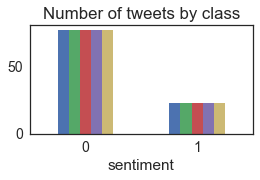

In [147]:
df2.groupby(['sentiment']).count().plot(kind='bar', figsize=(4, 2), rot=0, legend=False, title='Number of tweets by class')
plt.show()

In [148]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(df2['tokenized_int'].values, df2['sentiment'].values, test_size=0.25, random_state=0)
x_train_2 = pad_sequences(X_train_2, maxlen=maxlen, value=0)
x_valid_2 = pad_sequences(X_valid_2, maxlen=maxlen, value=0)
hot_y_2 = np_utils.to_categorical(y_train_2)
hot_y_valid_2 = np_utils.to_categorical(y_valid_2)

In [163]:
x_train.shape

(150000, 10)

In [172]:
#cnn_glove.predict(x_train[:10])

In [149]:
cnn_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 10, 50)            250000    
_________________________________________________________________
model_2 (Model)              (None, 64)                28992     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 25)                1625      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 52        
Total params: 559,661
Trainable params: 280,669
Non-trainable params: 278,992
_________________________________________________________________


D:\Programmes\Anaconda2\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [150]:
cnn_glove.get_layer("dropout_4").get_output_at(0)

<tf.Tensor 'dropout_4/cond/Merge:0' shape=(?, 64) dtype=float32>

In [151]:
from keras import models
from keras import layers
from keras import optimizers

def transfer_model(pretrained_model ): 
    # Create the model
    model = models.Sequential()

    # Add the first layers of the trained model :keep the output of the k_ième layer 
    # Ici on enlève les 2 dernières couches dense_11 et dense_12
    model.add(Model(inputs=pretrained_model.get_input_at(0) ,outputs=pretrained_model.get_layer("dropout_4").get_output_at(0)))
    #model.add(pretrained_model)  à la place de la ligne du dessus si pas besoin d'enlever les dernières couches 

    # Add new layers
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))


    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # Show a summary of the model. Check the number of trainable parameters
    print(model.summary())
    
    return model
    
    

In [152]:
trans_model = transfer_model(cnn_glove )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_12 (Model)             (None, 64)                278992    
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 50)                3250      
_________________________________________________________________
dropout_20 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 102       
Total params: 282,344
Trainable params: 3,352
Non-trainable params: 278,992
_________________________________________________________________
None


In [157]:
# avec transfer 
essai = trans_model.fit(x_train_2, hot_y_2, validation_data=(x_valid_2, hot_y_valid_2), epochs=10, batch_size=20)

Train on 75 samples, validate on 25 samples
Epoch 1/10
75/75 [==============================] - 0s 319us/step - loss: 0.4310 - acc: 0.8000 - val_loss: 0.2475 - val_acc: 0.9600
Epoch 2/10
75/75 [==============================] - 0s 199us/step - loss: 0.3631 - acc: 0.8333 - val_loss: 0.2463 - val_acc: 0.9600
Epoch 3/10
75/75 [==============================] - 0s 187us/step - loss: 0.4645 - acc: 0.7600 - val_loss: 0.2463 - val_acc: 0.9600
Epoch 4/10
75/75 [==============================] - 0s 186us/step - loss: 0.4973 - acc: 0.7467 - val_loss: 0.2473 - val_acc: 0.9600
Epoch 5/10
75/75 [==============================] - 0s 199us/step - loss: 0.4031 - acc: 0.8000 - val_loss: 0.2475 - val_acc: 0.9600
Epoch 6/10
75/75 [==============================] - 0s 199us/step - loss: 0.3621 - acc: 0.8467 - val_loss: 0.2462 - val_acc: 0.9600
Epoch 7/10
75/75 [==============================] - 0s 199us/step - loss: 0.4091 - acc: 0.8200 - val_loss: 0.2448 - val_acc: 0.9600
Epoch 8/10
75/75 [==============

In [158]:
# sans transfer 
cnn_glove1 = mult_conv_glove()
essai2 = cnn_glove1.fit(x_train_2, hot_y_2, validation_data=(x_valid_2, hot_y_valid_2), epochs=10, batch_size=20)


Train on 75 samples, validate on 25 samples
Epoch 1/10
75/75 [==============================] - 1s 17ms/step - loss: 1.0412 - acc: 0.3600 - val_loss: 0.5947 - val_acc: 0.6800
Epoch 2/10
75/75 [==============================] - 0s 598us/step - loss: 0.7583 - acc: 0.5133 - val_loss: 0.4574 - val_acc: 0.8800
Epoch 3/10
75/75 [==============================] - 0s 798us/step - loss: 0.6169 - acc: 0.6600 - val_loss: 0.4108 - val_acc: 0.8800
Epoch 4/10
75/75 [==============================] - 0s 838us/step - loss: 0.5859 - acc: 0.7133 - val_loss: 0.3818 - val_acc: 0.8800
Epoch 5/10
75/75 [==============================] - 0s 851us/step - loss: 0.4927 - acc: 0.7600 - val_loss: 0.3666 - val_acc: 0.8800
Epoch 6/10
75/75 [==============================] - 0s 811us/step - loss: 0.5611 - acc: 0.7200 - val_loss: 0.3560 - val_acc: 0.8800
Epoch 7/10
75/75 [==============================] - 0s 837us/step - loss: 0.5794 - acc: 0.6867 - val_loss: 0.3522 - val_acc: 0.8800
Epoch 8/10
75/75 [===============

# Analyse en temps réel 

On utilise la librairie tweepy pour accéder aux tweets en temps réel, textblob pour traduire les tweets en anglais (pour ceux qui ne le sont déja pas).

Déroulement : 
- On requete un mot clé, le code se charge de récolter les tweets contenant ce mot clé en direct 
- On traduit en anglais si nécessaire et on applique les prétraitements classiques sur les tweets 
- On utilise un des modèles (au choix ici cnn_glove) pour prédire le sentiment de chacun des tweets récoltés 

Une extension à cela pourrait être d'associer les sentiments des tweets à un topic modelling (associer les sujets aux sentiments )  par rapport à un mot clé, cela pourrait par exemple aider à décrytper des news autours d'un sujet/ d'une personne / d'une entreprise en tendance sur twitter 

In [201]:
def clean_tweet(tweet):
    dict= {}
    data = {'text': [tweet]}
    df3= pd.DataFrame.from_dict(data)
    df3['clean_text'] = tc.transform(df3['text'])
    df3['tokenized'] = df3['clean_text'].apply(lambda row: tokenize(row))
    df3['tokenized'] = df3['tokenized'].apply(lambda row: remove_stopwords(row))
    df3['tokenized_int'] = df3['tokenized'].apply(lambda x: transform_to_ids(x))
    x = df3['tokenized_int'].loc[0] 
    x= np.array(x)
    x = x.reshape(1,-1)
    x_pad = pad_sequences(x, maxlen=maxlen, value=0)
    
    return x_pad
tweet_int = clean_tweet("salut good and you happy !!!")
print(tweet_int)

np.argmax(cnn_glove.predict(tweet_int), axis= 1)[0]

[[ 0  0  0  0  0  0  0  0  2 53]]


1

In [205]:


import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 

class TwitterClient(object): 

    ''' 
    Generic Twitter Class for sentiment analysis. 
    '''
    def __init__(self):
        
        ''' 
        Class constructor or initialization method. 
        '''
        #Variables that contains the user credentials to access Twitter API 
        access_token = ""
        access_token_secret = "cr"
        consumer_key = ""
        consumer_secret = ""

        # attempt authentication 
        try: 
            # create OAuthHandler object 
            self.auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            self.auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            self.api = tweepy.API(self.auth) 
        except: 
            print("Error: Authentication Failed") 

   
    
    def clean_tweet(self,  tweet):
        dict= {}
        data = {'text': [tweet]}
        df3= pd.DataFrame.from_dict(data)
        df3['clean_text'] = tc.transform(df3['text'])
        df3['tokenized'] = df3['clean_text'].apply(lambda row: tokenize(row))
        df3['tokenized'] = df3['tokenized'].apply(lambda row: remove_stopwords(row))
        df3['tokenized_int'] = df3['tokenized'].apply(lambda x: transform_to_ids(x))
        x = df3['tokenized_int'].loc[0] 
        x= np.array(x)
        x = x.reshape(1,-1)
        x_pad = pad_sequences(x, maxlen=maxlen, value=0)

        return x_pad
    
    
    

    def get_tweet_sentiment(self, tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        #analysis = TextBlob(self.clean_tweet(tweet))
        
        # on utilise ici notre modèle cnn_glove (réseau convolutionel avec glove)
        
        tweet_int = self.clean_tweet(tweet)

        analysis = np.argmax(cnn_glove.predict(tweet_int), axis= 1)[0]
        # set sentiment 
        if analysis> 0: 
            return 'positive'
        else:
            return 'negative'

    def get_tweets(self, query, count = 10, traduction =True): 
        ''' 
        Main function to fetch tweets and parse them. 
        '''
        # empty list to store parsed tweets 
        tweets = [] 

        try: 
            # call twitter api to fetch tweets 
            fetched_tweets = self.api.search(q = query, count = count) 

            # parsing tweets one by one 
            for tweet in fetched_tweets: 
                # empty dictionary to store required params of a tweet 
                parsed_tweet = {} 

                
                
                # permet de traduire en anglais pour appliquer nos predictions sur des tweet de langues ! = anglais 
                if traduction == True:
                        # saving text of tweet 
                    try :
                        en_blob = TextBlob(tweet.text)
                        translate_tweet = str(en_blob.translate(to='en'))
                        parsed_tweet['text'] = translate_tweet
                        parsed_tweet['sentiment'] = self.get_tweet_sentiment(translate_tweet)
                    except : 
                        parsed_tweet['text'] = tweet.text 
                        # saving sentiment of tweet 
                        parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text) 
                        
                else:
                         # saving text of tweet 

                    parsed_tweet['text'] = tweet.text     
                    # saving sentiment of tweet 
                    parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text)  
                    

                # appending parsed tweet to tweets list 
                if tweet.retweet_count > 0: 
                    # if tweet has retweets, ensure that it is appended only once 
                    if parsed_tweet not in tweets: 
                        tweets.append(parsed_tweet) 
                else: 
                    tweets.append(parsed_tweet) 

            # return parsed tweets 
            return tweets 

        except tweepy.TweepError as e: 
            # print error (if any) 
            print("Error : " + str(e)) 

def main(): 
    # creating object of TwitterClient Class 
    api = TwitterClient() 
    # calling function to get tweets 
    tweets = api.get_tweets(query = 'trump', count = 200) 

    # picking positive tweets from tweets 
    ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive'] 
    # percentage of positive tweets 
    print("Positive or neutral tweets percentage: {} %".format(100*len(ptweets)/len(tweets))) 
    # picking negative tweets from tweets 
    ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative'] 
    # percentage of negative tweets 
    print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets))) 
   
  

    # printing first 5 negative tweets 
    print("\n\nNegative tweets:") 
    for tweet in ntweets[:10]: 
        print(tweet['text']) 
        
    
    # printing first 5 positive tweets 
    print("\n\nPositive tweets:") 
    for tweet in ptweets[:10]: 
        print(tweet['text']) 

    # printing first 5 neutral tweets 
    print("\n\nNombre de tweets :") 
    print(len(tweets))
    print(tweets[:5])
    
    
if __name__ == "__main__": 
    # calling main function 
    main() 


Positive or neutral tweets percentage: 55.913978494623656 %
Negative tweets percentage: 44.086021505376344 %


Negative tweets:
RT @MaddowBlog: If that quarter billion dollar magic trick Donald Trump tried to play with that financial statement is, in fact, evidence o…
RT @realJeffreyP: Remember, frmr. U.S. Attorney Dennis Burke, my old colleague, was the United States Attorney who resigned in shame during…
RT @leeleeb50: Due to the success of the 5 D's of trump, I thought I should start from the beginning....with A

asshole
asshat
assclown
aby…
RT @sbg1: The bills are coming due for Trump, and if there’s one thing we know about the President it’s that he doesn’t like to pay his bil…
RT @scooze007: @realDonaldTrump You should be worried about the lies you told on security clearances for your family. I would think you are…
@Musicbizfraud @CNN @MichaelCohen212 @realDonaldTrump You have a poor understanding of how politics work.  Trump is… https://t.co/wAvS6C3Zs5
RT @SitterKitty: A person 

In [159]:
# version orignale avec TextBlob 

import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 

class TwitterClient(object): 

    ''' 
    Generic Twitter Class for sentiment analysis. 
    '''
    def __init__(self):
        
        ''' 
        Class constructor or initialization method. 
        '''
        #Variables that contains the user credentials to access Twitter API 
        access_token = ""
        access_token_secret = "cr"
        consumer_key = ""
        consumer_secret = ""

        # attempt authentication 
        try: 
            # create OAuthHandler object 
            self.auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            self.auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            self.api = tweepy.API(self.auth) 
        except: 
            print("Error: Authentication Failed") 

    def clean_tweet(self, tweet): 
        ''' 
        Utility function to clean tweet text by removing links, special characters 
        using simple regex statements. 
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", tweet).split()) 

    def get_tweet_sentiment(self, tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(self.clean_tweet(tweet)) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'

    def get_tweets(self, query, count = 10, traduction =True): 
        ''' 
        Main function to fetch tweets and parse them. 
        '''
        # empty list to store parsed tweets 
        tweets = [] 

        try: 
            # call twitter api to fetch tweets 
            fetched_tweets = self.api.search(q = query, count = count) 

            # parsing tweets one by one 
            for tweet in fetched_tweets: 
                # empty dictionary to store required params of a tweet 
                parsed_tweet = {} 

                
                
                
                # ICI que les modifs sont à faire 
                # permet de traduire en anglais pour appliquer nos predictions sur des tweet 
                if traduction == True:
                        # saving text of tweet 
                    try :
                        en_blob = TextBlob(tweet.text)
                        translate_tweet = str(en_blob.translate(to='en'))
                        parsed_tweet['text'] = translate_tweet
                        parsed_tweet['sentiment'] = self.get_tweet_sentiment(translate_tweet)
                    except : 
                        parsed_tweet['text'] = tweet.text 
                        # saving sentiment of tweet 
                        parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text) 
                        
                else:
                         # saving text of tweet 

                    parsed_tweet['text'] = tweet.text     # appliquer les traitements habituel sur les textes comme sur le notebook 

                    # saving sentiment of tweet 
                    parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text)   # au lieu d'utiliser cette fonction on appelle la fonction predict (cnn, rnn )

                    
                    
                    
                    
                    
                    
                    

                # appending parsed tweet to tweets list 
                if tweet.retweet_count > 0: 
                    # if tweet has retweets, ensure that it is appended only once 
                    if parsed_tweet not in tweets: 
                        tweets.append(parsed_tweet) 
                else: 
                    tweets.append(parsed_tweet) 

            # return parsed tweets 
            return tweets 

        except tweepy.TweepError as e: 
            # print error (if any) 
            print("Error : " + str(e)) 

def main(): 
    # creating object of TwitterClient Class 
    api = TwitterClient() 
    # calling function to get tweets 
    tweets = api.get_tweets(query = 'PSG', count = 200) 

    # picking positive tweets from tweets 
    ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive'] 
    # percentage of positive tweets 
    print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets))) 
    # picking negative tweets from tweets 
    ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative'] 
    # percentage of negative tweets 
    print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets))) 
    # percentage of neutral tweets 
    print("Neutral tweets percentage: {} % \ ".format(100*(len(tweets) - len(ntweets) - len(ptweets))/len(tweets))) 

    # printing first 5 positive tweets 
    print("\n\nPositive tweets:") 
    for tweet in ptweets[:10]: 
        print(tweet['text']) 

    # printing first 5 negative tweets 
    print("\n\nNegative tweets:") 
    for tweet in ntweets[:10]: 
        print(tweet['text']) 

    # printing first 5 neutral tweets 
    print("\n\nNombre de tweets :") 
    print(len(tweets))
    print(tweets[:5])
    
    
if __name__ == "__main__": 
    # calling main function 
    main() 


Positive tweets percentage: 34.666666666666664 %
Negative tweets percentage: 12.0 %
Neutral tweets percentage: 53.333333333333336 % \ 


Positive tweets:
"Manchester, we think about it, but we want to win in Caen," says Thomas Tuchel https://t.co/xQqr31hJzU
RT @Juampi_HWJ: You still have to remember that the channel Team 21 made a special Manchester United night the day before the match at Old ...
RT @SiPhillipsSport: Real Madrid’s move for Eden Hazard is dependent upon prising Neymar or Kylian Mbappe away from PSG.

Hazard is therefo…
RT @abdellahboulma: If the PSG wins the Coupe de France this year, it will be its 13th trophy in 49 years including 8 trophies before the arrival of ...
RT @360Sources: David de Gea wants over £385,000 per week but Manchester United don’t want to pay this astronomical fee. DDG’s agent Jorge…
@Pallomari1 Guendouzi 20 years old starter week in week out playing in Europe and PSG interested apparently! £2.99 Low risk
RT @oAzzoo: Top 10 deal manufacturers (cl